# Overview

The [timecorr](https://timecorr.readthedocs.io/en/latest/) Python toolbox provides tools for computing and exploring the correlational structure of timeseries data.  The details of this approach are described in [this preprint](https://www.biorxiv.org/content/10.1101/763821v1); some excerpts from the methods of that paper are reproduced below for convenience.

In its most basic usage, the `timecorr` function provided by the toolbox takes as input a number-of-timepoints ($T$) by number-of-features ($K$) matrix, and returns as output a $K \times K \times T$ tensor containing a timeseries of the moment-by-moment correlations reflected in the data.  There are two additional special features of the timecorr toolbox that we'll also explore in this tutorial: dynamic inter-subject functional correlations and high-order dynamic correlations.  Before explaining those additional features, we'll expand on how timecorr estimates dynamic correlations from multi-dimensional timeseries data.

Given a $T$ by $K$ matrix of observations, $\mathbf{X}$, we can compute the (static) Pearson's correlation between any pair of columns, $\mathbf{X}(\cdot, i)$ and $\mathbf{X}(\cdot, j)$ using:
$$
\begin{align}
  \mathrm{corr}(\mathbf{X}(\cdot, i), \mathbf{X}(\cdot, j)) &=
                                                              \frac{\sum_{t=1}^T
                                                              \left(\mathbf{X}(t,
                                                              i)
                                                              -
                                                              \bar{\mathbf{X}}(\cdot,
                                                              i)\right)
                                                              \left(\mathbf{X}(t,
                                                              j)
                                                              -
                                                              \bar{\mathbf{X}}(\cdot, j)\right)}{\sqrt{\sum_{t=1}^T
                                                              \sigma^2_{\mathbf{X}(\cdot, i)} 
                                                              \sigma^2_{\mathbf{X}(\cdot, j)}}},~\mathrm{where}\label{eqn:corr}\\
  \bar{\mathbf{X}}(\cdot, k) &= \frac{1}{T}\sum_{t=1}^T
                               \mathbf{X}(t, k),~\mathrm{and}\\
  \sigma^2_{\mathbf{X}(\cdot, k)} &= \frac{1}{T}\sum_{t=1}^T \left( \mathbf{X}(t, k) -
                                    \bar{\mathbf{X}}(\cdot, k) \right)^2 
\end{align}
$$

We can generalize this formula to compute time-varying correlations by incorporating a *kernel function* that takes a time $t$ as input, and returns how much the observed data at each timepoint $\tau \in \left[ -\infty, \infty \right]$ contributes to the estimated instantaneous correlation at time $t$.

Given a kernel function $\kappa_t(\cdot)$ for timepoint $t$, evaluated at timepoints $\tau \in \left[ 1, ..., T \right]$, we can update the static correlation formula above to estimate the *instantaneous correlation* at timepoint $t$:

$$
\begin{align}
  \mathrm{timecorr}_{\kappa_t}\left(\mathbf{X}(\cdot, i), \mathbf{X}(\cdot, j)\right) &= \frac{\sum_{\tau=1}^T \left( \mathbf{X}(\tau, i) -
                                       \widetilde{\mathbf{X}}_{\kappa_t}(\cdot,
                                                                                        i) \right)
                                 \left( \mathbf{X}(\tau, j) -
                                        \widetilde{\mathbf{X}}_{\kappa_t}(\cdot,
                                                                                        j)\right)}
              {\sqrt{\sum_{\tau=1}^T
                                              \widetilde{\sigma}_{\kappa_t}^2(\mathbf{X}(\cdot,
                                                                                        i))
                                              \widetilde{\sigma}_{\kappa_t}^2(\mathbf{X}(\cdot, j))}},~\mathrm{where}\label{eqn:timecorr}\\
  \widetilde{\mathbf{X}}_{\kappa_t}(\cdot, k) &= \sum_{\tau=1}^T
                       \kappa_t(\tau)\mathbf{X}(\tau, k),~\mathrm{and}\\
  \widetilde{\sigma}_{\kappa_t}^2(\mathbf{X}(\cdot, k)) &= \sum_{\tau=1}^T
                                                  \left(
                                                  \mathbf{X}(\tau, k) -
                            \widetilde{\mathbf{X}}_{\kappa_t}(\cdot, k) \right)^2.
\end{align}
$$

Here
$\mathrm{timecorr}_{\kappa_t}(\mathbf{X}(\cdot, i), \mathbf{X}(\cdot,
j))$ reflects the correlation at time $t$ between columns $i$ and $j$
of $\mathbf{X}$, estimated using the kernel $\kappa_t$.  We evaluate
the timecorr equation in turn for each pair of columns in
$\mathbf{X}$ and for kernels centered on each timepoint in the
timeseries, respectively, to obtain a $K \times K \times T$ timeseries of
dynamic correlations, $\mathbf{Y}$.

## Dynamic inter-subject functional correlations (dISFC)

Given a multi-subject dataset, [Simony et al. (2016)](https://www.nature.com/articles/ncomms12141.pdf) define a measure of stimulus-driven inter-regional correlations called inter-subject functional correlation (ISFC).  The timecorr toolbox extends this idea to compute a timeseries of ISFC matrices from a multi-subject dataset.  (The original ISFC approach computes a static ISFC matrix, although the authors of the original study use a sliding window approach to approximate a timeseries.)

## Dynamic high-order functional correlations

The image below summarizes a variety of neural patterns that one could (in principle) compute or estimate from a neural dataset.  Within-brain analyses are carried out within a single brain, whereas across-brain analyses compare neural patterns across two or more individuals' brains.  Univariate analyses characterize the activities of individual units (e.g., nodes, small networks, hierarchies of networks, etc.), whereas multivariate analyses characterize the patterns of activities across units.  Order 0 patterns involve individual nodes; order 1 patterns involve node-node interactions; order 2 (and higher) patterns relate to interactions between homologous networks.  Each of these patterns may be static (e.g., averaging over time) or dynamic.

![500px](patterns.jpg)

Computing high-order functional correlations naively would be computationally intractable for even modest numbers of nodes (brain regions) and orders.  This is because the resulting patterns at each timepoint scale exponentially with the order of interactions one attempts to investigate.  To make the computations tractable, we use the so-called [kernel trick](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f) popularized in classification approaches.  Rather than carrying out the computations in the "native" feature space (i.e., exponential scaling), we first project the data onto a much lower dimensional space (with $K$ dimensions), and then we perform the key computations in the low-dimensional space.  This enables us to achieve linear scaling with the order of functional correlations, at the expense of precision (since low-dimensional embeddings are lossy).  We primarily use two approaches for "embedding" the high-dimensional dynamic correlations in a $K$-dimensional space:

![400px](reduce.jpg)

*Dimensionality reduction* approaches take the $\mathcal{O}(K^2)$ patterns and embed them in a $K$-dimensional space that preserves (to the extent possible) the relations between the patterns at different timepoints.  *Graph measure* approaches forgo attempts to preserve the original activity patterns in favor of instead preserving each node's changing positions within the broader network (with respect to other nodes).

An overview of the timecorr approach, along with a summary of some of the key findings from [this paper](https://www.biorxiv.org/content/10.1101/763821v1) may be found in this video (credit: [Lucy Owen](https://lucywowen.github.io/)).

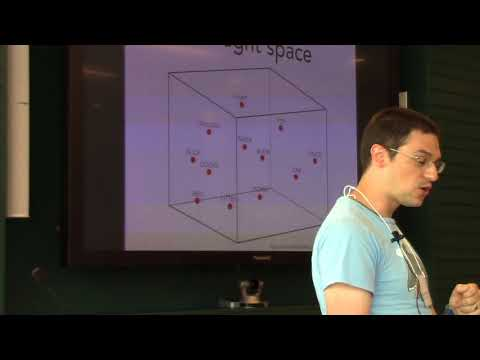

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('hb_ER9RGtOM') #replace with lucy's video

## Download Sherlock dataset

Follow the instructions [here](http://naturalistic-data.org/features/notebooks/Download_Data.html) to download the Sherlock datasets using DataLad.  In brief, navigate to a directory where you want to save the datasets (let's refer to it as `datadir`) and run the following command in Terminal:
```
datalad install -g https://gin.g-node.org/ljchang/Sherlock
```
In the next cell, set the variable `datadir` to the actual path you chose (e.g. `~/data`)

In [2]:
import os
datadir = os.path.join(os.getenv('HOME'), 'data')

# Import libraries

In [3]:
from glob import glob as lsdir
import numpy as np
import pandas as pd
from nltools.mask import create_sphere, expand_mask
from nltools.data import Brain_Data, Adjacency
from nilearn.plotting import plot_stat_map

import timecorr as tc
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

# A region of interest-based approach to inferring dynamic correlations

To speed up our computations and make the final results easier to visualize, we'll use timecorr to estimate connectivity patterns between regions of interest, rather than between the original voxels.

threshold is ignored for simple axial plots


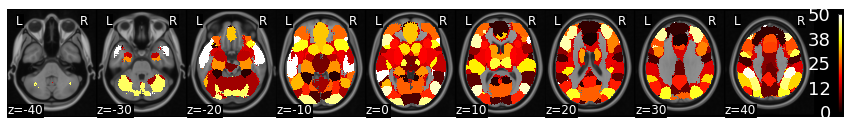

In [7]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
vectorized_mask = expand_mask(mask)
mask.plot()

In [8]:
rois = pd.read_csv('https://raw.githubusercontent.com/naturalistic-data-analysis/tutorial_development/master/hypertools/rois.csv', header=None, names=['ID', 'Region'])
rois.head()

,ID,Region
0,0,Anterior MPFC
1,1,Fusiform/parahippocampus
2,2,DMPFC
3,3,Sensorimotor/postcentral gyrus
4,4,V1


In [9]:
def batch_extract_roi(fname_template, mask):
    fnames = lsdir(fname_template)
    roi_data = []
    for f in fnames:
        print('extracting ROI activity for ' + f)
        roi_data.append(Brain_Data(f).extract_roi(mask, method='mean'))
    return roi_data

In [11]:
# define filename templates
sherlock_part1 = os.path.join(datadir, 'Sherlock', 'fmriprep', '*', 'func', '*crop*Part1*hdf5')
sherlock_part2 = os.path.join(datadir, 'Sherlock', 'fmriprep', '*', 'func', '*crop*Part2*hdf5')

In [261]:
data = {'part 1': batch_extract_roi(sherlock_part1, mask), 'part 2': batch_extract_roi(sherlock_part2, mask)}

extracting data for ROI 4: /Users/jmanning/data/Sherlock/fmriprep/sub-13/func/sub-13_denoise_crop_smooth6mm_task-sherlockPart1_space-MNI152NLin2009cAsym_desc-preproc_bold.hdf5


OSError: ``/Users/jmanning/data/Sherlock/fmriprep/sub-13/func/sub-13_denoise_crop_smooth6mm_task-sherlockPart1_space-MNI152NLin2009cAsym_desc-preproc_bold.hdf5`` does not exist

- simulate second-order timeseries and recover patterns using timecorr
- get mean patterns in each ROI and use timecorr to compute first-order, second-order, and third-order ISFC dynamics
- generate an animated network plot showing each pattern

# Further reading

[This paper](https://www.biorxiv.org/content/10.1101/763821v1) provides additional methods details, along with some interesting findings and insights obtained using timecorr to analyze an fMRI dataset.  The code used in that paper (along with links to download the data) may be found [here](https://github.com/ContextLab/timecorr-paper).  Some additional timecorr tutorials may be found [here](https://timecorr.readthedocs.io/en/latest/tutorials.html).

What we refer to as second-order dynamic correlations has been discovered in parallel work by [Jo et al. (2020)](https://www.biorxiv.org/content/10.1101/2020.05.05.067777v1).  In their preprint, they describe analogous patterns as "edge communities" that yield stable person-specific patterns.